<h1>Project: Fundamentals of Information Systems </h1>

<h3>Introduction</h3>

This data has been gathered at **two solar power plants** in India over a **34 day** period. It has **two** pairs of files - each pair has **one power generation dataset** and **one sensor readings dataset**. 
- The **power generation datasets** are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. 
- The **sensor data** is gathered at a plant level - a single array of sensors optimally placed at the plant.

# Output

**Questions:**
 - What is the **mean** value of **daily yield**? 
 - What is the **total irradiation per day**? 
 - What is the **max ambient** and **module temperature**? 
 - **How many inverters** are there **for each plant**? 
 - What is the **maximum/minimum amount** of **DC/AC Power generated** in a **time interval/day**? 
 - **Which inverter** (source_key) has produced **maximum DC/AC power**? 
 - **Rank the inverters** based on the **DC/AC power** they produce? Is there **any missing data**?
 
 
 - Graphs that explain the patterns for attributes independent of other variables. These will usually be tracked as changes of attributes against DATETIME, DATE, or TIME. 
**Examples.** How is DC or AC Power changing as time goes by? how is irradiation changing as time goes by? how are ambient and module temperature changing as time goes by? how does yield change as time goes by? Explore plotting variables against different granularities of DATETIME and which is the best option for each variable.

#  Variables

**Power generation data**
- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
 
- PLANT_ID: Plant ID - this will be common for the entire file.
 
- SOURCE_KEY: Source key in this file stands for the inverter id.
 
- DC_POWER: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
 
- AC_POWER: Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
 
- DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time.
 
- TOTAL_YIELD: This is the total yield for the inverter till that point in time.
 
**Weather sensor data**
 - DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
 
 - PLANT_ID: Plant ID - this will be common for the entire file.
 
 - SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.
 
 - AMBIENT_TEMPERATURE: This is the ambient temperature at the plant.
 
 - MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.
 
 - IRRADIATION: Amount of irradiation for the 15 minute interval.



<h5>Libraries needed</h5>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

**Data**

In [3]:
p1_gen = pd.read_csv('Plant_1_Generation_data.csv')
p1_wea = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
p2_gen = pd.read_csv("Plant_2_Generation_data.csv") 
p2_wea = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

In [5]:
print("Shape of the table for plant 1 generation data: ", p1_gen.shape)
print("Shape of the table for plant 2 generation data: ",p2_gen.shape)
print("Name of the columns for the dataframes: \n",list(p1_gen.columns))
assert(np.all(p1_gen.columns == p2_gen.columns))  # just making sure they have the same columns

Shape of the table for plant 1 generation data:  (68778, 7)
Shape of the table for plant 2 generation data:  (67698, 7)
Name of the columns for the dataframes: 
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']


In [7]:
print("Shape of the table for weather sensor plant 1: ", p1_wea.shape)
print("Shape of the table for weather sensor plant 2: ", p2_wea.shape)
print("Column names for weather sensor tables: \n", list(p1_wea.columns))
assert(np.all(p1_wea.columns == p2_wea.columns)) # just making sure they have the same columns

Shape of the table for weather sensor plant 1:  (3182, 6)
Shape of the table for weather sensor plant 2:  (3259, 6)
Column names for weather sensor tables: 
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


<h3> DATA CLEANING </h3>

In [8]:
### the format of the dates in the DATE_TIME column is different between df p1_gen and p2_gen;
### if we want to join them it's better to convert to the same format

def convert_dates(date):
    return date[8:10]+date[4:8]+date[:4]+date[10:-3]

p2_gen.DATE_TIME = p2_gen.DATE_TIME.apply(convert_dates)

In [9]:
### we concatenate the two dataframes regarding the inverters

panels = pd.concat([p1_gen,p2_gen])

In [11]:
### grouping by day is going to be much easier for the computations we'll have to do
### we create a day column for the inverters dataframe, which ignores the hour of the relevation

panels["DAY"] = panels.DATE_TIME.apply(lambda x: datetime.datetime.strptime(x,"%d-%m-%Y %H:%M").date())

assert(panels.shape == (p1_gen.shape[0]+p2_gen.shape[0],p1_gen.shape[1]+1)) # just to check dimensions are fine after the merge
panels.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DAY
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,2020-05-15
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,2020-05-15
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,2020-05-15
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,2020-05-15


In [12]:
### we do the same for the sensors, concatenating the two dataframes and creating a new column for the day

sensors = pd.concat([p1_wea,p2_wea])
sensors["DAY"] = sensors.DATE_TIME.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date())

assert(sensors.shape == (p1_wea.shape[0]+p2_wea.shape[0],p1_wea.shape[1]+1)) # just to check dimensions are fine after the merge
sensors.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,2020-05-15
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,2020-05-15
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,2020-05-15
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,2020-05-15


<h3> QUESTIONS </h3>

<h6>What is the mean value of daily yield?</h6>

In [14]:
### we group by inverter ID and day, considering the maximum per day 
### (daily yield gets resetted at midnight so we're basically choosing the last daily_yield relevation per day per source)

grouped_df = panels.DAILY_YIELD.groupby([panels.SOURCE_KEY,panels.DAY]).max().reset_index()

In [15]:
grouped_df.head()

,SOURCE_KEY,DAY,DAILY_YIELD
0,1BY6WEcLGh8j5v7,2020-05-15,5754.0
1,1BY6WEcLGh8j5v7,2020-05-16,6292.0
2,1BY6WEcLGh8j5v7,2020-05-17,7045.0
3,1BY6WEcLGh8j5v7,2020-05-18,4998.0
4,1BY6WEcLGh8j5v7,2020-05-19,6449.0


We can compute the mean daily yield per inverter (and plot the distribution)

In [63]:
## we consider the mean daily_yield per source_key and we plot it as an histogram

mean_yields_per_inverter = grouped_df.DAILY_YIELD.groupby(grouped_df.SOURCE_KEY).mean().reset_index()

In [64]:
mean_yields_per_inverter.head()

,SOURCE_KEY,DAILY_YIELD
0,1BY6WEcLGh8j5v7,6639.865546
1,1IF53ai7Xc0U56Y,7348.806373
2,3PZuoBAID5Wc2HD,7341.279412
3,4UPUqMRk7TRMgml,7703.903782
4,7JYdWkrLSPkdwr4,7172.323529


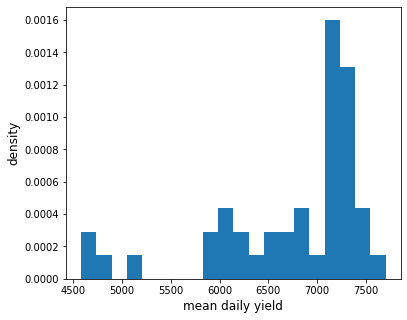

In [19]:
plt.figure(figsize=(6,5))
plt.hist(mean_yields_per_inverter.DAILY_YIELD,density=True,bins=20)
plt.xlabel("mean daily yield",fontsize=12)
plt.ylabel("density",fontsize=12)
plt.show()

In [20]:
mean_inverter_daily_yield = mean_yields_per_inverter.DAILY_YIELD.mean()

In [74]:
print(f"The mean inverter daily yield, calculated considering all panels, is {round(mean_inverter_daily_yield,2)} kW/day.")

The mean inverter daily yield, calculated considering all panels, is 6743.89 kW/day.


We can instead compute the total daily yield considering every inverter and grouping by day

In [22]:
total_daily_yields = grouped_df.DAILY_YIELD.groupby(grouped_df.DAY).sum().reset_index()

In [23]:
total_daily_yields.head()

,DAY,DAILY_YIELD
0,2020-05-15,306829.000000
1,2020-05-16,289470.933333
2,2020-05-17,304520.000000
3,2020-05-18,249897.000000
4,2020-05-19,266590.125000


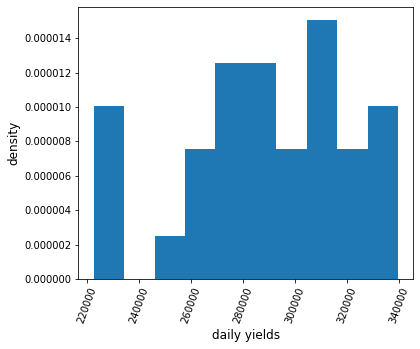

In [24]:
plt.figure(figsize=(6,5))
plt.hist(total_daily_yields.DAILY_YIELD,density=True,bins=10)
plt.xlabel("daily yields",fontsize=12)
plt.ylabel("density",fontsize=12)
plt.xticks(rotation=70)
plt.show()

In [73]:
mean_total_daily_yield = total_daily_yields.DAILY_YIELD.mean()
print(f"Mean total daily yield is {round(mean_total_daily_yield,2)} kW/day.")

Mean total daily yield is 290010.72 kW/day.


Idee, osservazioni per domande,probabilmente da segnalare all'inizio: (**MISSING DATA**)

In [75]:
#### missing data: some inverters are missing data (indices 8,13,28,39 of command below)

# grouped_df.DAY.groupby(grouped_df.SOURCE_KEY).count().reset_index()

#### they all have 8 days of missing data (26 instead of 34) (TOTAL 4*8 = 32 missing data entries)

In [76]:
### in fact between 21/05 and 28/05 we have 4 less data entries per day (8*4 = 32 missing data entries)
### command below shows this

# grouped_df.SOURCE_KEY.groupby(grouped_df.DAY).count().reset_index()

<h6>What is the total irradiation per day?</h6>

In [26]:
sensors.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,2020-05-15
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,2020-05-15
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,2020-05-15
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,2020-05-15


In [27]:
irr_per_day_df = sensors.IRRADIATION.groupby(sensors.DAY).sum().reset_index()

In [28]:
irr_per_day_df.head()

,DAY,IRRADIATION
0,2020-05-15,47.596065
1,2020-05-16,42.328263
2,2020-05-17,44.164973
3,2020-05-18,36.762265
4,2020-05-19,38.390182


we can see how irradiation correlates to the total daily yield obtained:

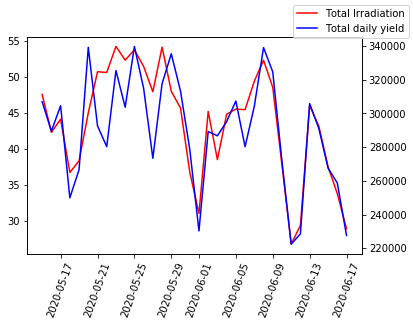

In [49]:
fig,ax = plt.subplots()
plt.xticks(rotation=70)
ax.plot(irr_per_day_df.DAY,irr_per_day_df.IRRADIATION,color="red")
ax2 = ax.twinx()
ax2.plot(total_daily_yields.DAY,total_daily_yields.DAILY_YIELD,color="blue")
fig.legend(["Total Irradiation","Total daily yield"],loc=1)
plt.show()

# the descrepancy between 21/05 and 28/05 is due to missing data as reported above

<h6>What is the max ambient and module temperature?</h6>

In [51]:
ambient_temp = sensors.AMBIENT_TEMPERATURE.max()
print("max ambient temperature:",round(ambient_temp,2))
module_temp = sensors.MODULE_TEMPERATURE.max()
print("max module temperature:",round(module_temp,2))

max ambient temperature: 39.18
max module temperature: 66.64


<h6>How many inverters are there for each plant?</h6>

In [58]:
plant1_panels = len(p1_gen.SOURCE_KEY.unique())
plant2_panels = len(p2_gen.SOURCE_KEY.unique())

print(f"There are {plant1_panels} inverters in plant 1.")
print(f"There are {plant2_panels} inverters in plant 2.")

There are 22 inverters in plant 1.
There are 22 inverters in plant 2.


<h6>What is the maximum/minimum amount of DC/AC Power generated in a time interval/day?</h6>

In [52]:
dc_power_per_day = panels.DC_POWER.groupby(panels.DAY).sum().reset_index()
ac_power_per_day = panels.AC_POWER.groupby(panels.DAY).sum().reset_index()

In [53]:
dc_power_per_day.head()

,DAY,DC_POWER
0,2020-05-15,6.293847e+06
1,2020-05-16,6.372977e+06
2,2020-05-17,7.315831e+06
3,2020-05-18,5.343322e+06
4,2020-05-19,5.881451e+06


In [54]:
ac_power_per_day.head()

,DAY,AC_POWER
0,2020-05-15,1.202269e+06
1,2020-05-16,1.122613e+06
2,2020-05-17,1.205368e+06
3,2020-05-18,9.899823e+05
4,2020-05-19,9.658052e+05


In [55]:
print(f"Maximum DC POWER per day: {max(dc_power_per_day.DC_POWER)}")
print(f"Minimum DC POWER per day: {min(dc_power_per_day.DC_POWER)}")
print(f"Maximum AC POWER per day: {max(ac_power_per_day.AC_POWER)}")
print(f"Minimum AC POWER per day: {min(ac_power_per_day.AC_POWER)}")

Maximum DC POWER per day: 8481752.452106627
Minimum DC POWER per day: 5343322.2128492575
Maximum AC POWER per day: 1341152.419407102
Minimum AC POWER per day: 830022.6846618616


**....altre domande** (TODO)

<h5>parte grafica</h5> (totalmente da fare, solo un esempio) (TODO)

e.g. how are ambient and module temperature changing as time goes by?

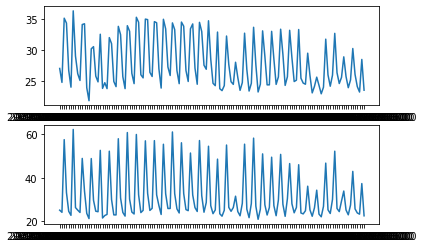

In [17]:
# per esempio per un specifico sensore
first_sensor_df = sensor2[sensor2["SOURCE_KEY"]=="iq8k7ZNt4Mwm3w0"]
first_sensor_df.shape
plt.subplot(2,1,1)
plt.plot(first_sensor_df["DATE_TIME"][::24],first_sensor_df["AMBIENT_TEMPERATURE"][::24])
plt.subplot(2,1,2)
plt.plot(first_sensor_df["DATE_TIME"][::24],first_sensor_df["MODULE_TEMPERATURE"][::24])
plt.show()